In [1]:
pip install kagglehub


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adrianmcmahon/imdb-india-movies")

print("Path to dataset files:", path)
import os

os.listdir(path)



Path to dataset files: /Users/apple/.cache/kagglehub/datasets/adrianmcmahon/imdb-india-movies/versions/1


['IMDb Movies India.csv']

Initial shape: (15509, 10)
Fitting model...
RMSE: 1.0659377519262774
R2 Score: 0.37510959699054336


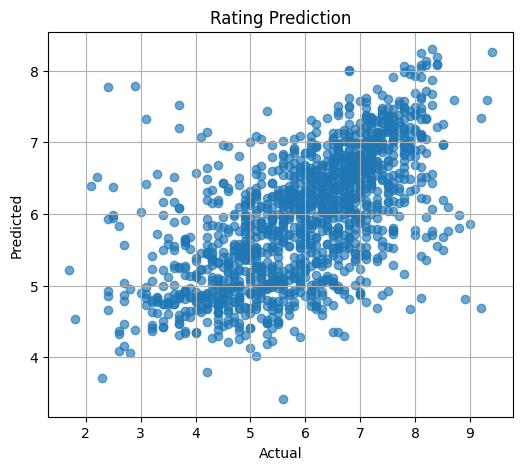


Top Features:

Votes                        0.202043
Year                         0.175103
Duration                     0.087496
Genre_Drama                  0.029852
Genre_Documentary            0.014413
Actor 3_nan                  0.009131
Actor 1_Salman Khan          0.006333
Genre_Horror                 0.005171
Genre_Horror, Thriller       0.003612
Actor 2_Ameesha Patel        0.003210
Genre_Drama, Family          0.003185
Genre_Action                 0.003134
Genre_Comedy, Drama          0.002958
Actor 1_Akshay Kumar         0.002912
Actor 1_Himesh Reshammiya    0.002817
dtype: float64


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("IMDb Movies India.csv")
print("Initial shape:", df.shape)


#Cleaning

# Extract year 
df["Year"] = df["Year"].str.extract(r"(\d{4})")

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Duration looks like "123 min" so pull digits
dur = df["Duration"].str.extract(r"(\d+)")   # temp var to inspect
df["Duration"] = pd.to_numeric(dur[0], errors="coerce")

# Votes sometimes contain commas -> remove
df["Votes"] = (
    df["Votes"]
    .astype(str)
    .str.replace(",", "", regex=False)
)
df["Votes"] = pd.to_numeric(df["Votes"], errors="coerce")

# Drop missing ratings 
df = df.dropna(subset=["Rating"])

# Drop rows missing important stuff
needed_cols = ["Genre","Director","Actor 1","Duration","Votes","Year"]
df = df.dropna(subset=needed_cols)

# Features/target
X = df[["Genre","Director","Actor 1","Actor 2","Actor 3","Duration","Votes","Year"]]
y = df["Rating"]

# Split categorical & numeric
cat_cols = ["Genre","Director","Actor 1","Actor 2","Actor 3"]
num_cols = ["Duration","Votes","Year"]


preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),("num", "passthrough", num_cols),
    ],
    remainder="drop",
)


rf = RandomForestRegressor(
    n_estimators=160,
    random_state=42,
    n_jobs=-1
)

# Build pipeline
pipe = Pipeline([
    ("prep", preprocessor),
    ("model", rf)
])

# Train/val split
trainX, valX, trainY, valY = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Fitting model...")
pipe.fit(trainX, trainY)

# Predictions
preds = pipe.predict(valX)

rmse = np.sqrt(mean_squared_error(valY, preds))
r2 = r2_score(valY, preds)

print("RMSE:", rmse)
print("R2 Score:", r2)


plt.figure(figsize=(6,5))
plt.scatter(valY, preds, alpha=0.65)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Rating Prediction")
plt.grid(True)
plt.show()

ohe = pipe.named_steps["prep"].named_transformers_["cat"]
ohe_cols = list(ohe.get_feature_names_out(cat_cols))

all_cols = ohe_cols + num_cols

importances = pipe.named_steps["model"].feature_importances_
imp_series = pd.Series(importances, index=all_cols).sort_values(ascending=False)

print("\nTop Features:\n")
print(imp_series.head(15))
